# Simulated Annealing as a Meta heuristic for the FSS problem


In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import plotly.figure_factory as ff
import plotly.express as px
from datetime import timedelta

In [218]:
class SolveFSSP:
    def __init__(
        self,
        csv_path: str,
        initial_temperature: float,
        final_temperature: float,
        cooling_rate: float,
        max_iterations: int,
    ) -> None:
        """
        m: number of machines/operations
        n: number of jobs
        """
        self.p, self.r_hat, self.d_hat = self.load_dataset(csv_path)
        self.m, self.n = self.p.shape

        self.initial_temperature = initial_temperature
        self.final_temperature = final_temperature
        self.cooling_rate = cooling_rate
        self.max_iterations = max_iterations

        self.S = np.zeros((self.m, self.n))  # Job start matrix
        self.C = np.zeros((self.m, self.n))  # Job completion matrix

    def load_dataset(self, csv_path):
        """loads dataset in csv_path

        Args:
            csv_path (str): relative path of dataset

        Returns:
            p (list[list[int]]): (m, n) processing time matrix
            r_hat (list[int]): (m,) minimum idle time per machine
            d_hat (list[int]): (m,) maximum idle time per machine
        """
        p = pd.read_csv(csv_path)
        r_hat = np.array(p["r_a"])
        d_hat = np.array(p["d_a"])
        p = np.array(p.drop(["r_a", "d_a"], axis=1))
        return np.array(p), np.array(r_hat), np.array(d_hat)

    def initial_solution(self):
        """inializes the solution (permutations for each machine) array

        Returns:
            list[list[int]]: matrix of permuations for each machine
        """
        return [[i for i in range(self.n)] for _ in range(self.m)]

    def calculate_times(self, solution):
        """Calculates the start and completion times matrices S and C.

        Args:
            solution ( list[list[int]] ): matrix of permutations for each machine

        Returns:
            tuple: (S, C) matrices of start and completion times
        """
        S = np.zeros((self.m, self.n))
        C = np.zeros((self.m, self.n))

        for i in range(self.m):  # for each machine
            for j in range(self.n):  # for each job
                job = solution[i][j]
                # print(f"dealing with operation {i} of job {job}")

                if i == 0:  # first machine
                    if j == 0:
                        S[i][job] = 0
                    else:
                        S[i][job] = C[i][solution[i][j - 1]] + self.r_hat[i]
                        # print("S[i][job]: ", S[i][job])

                else:  # subsequent machines
                    if j == 0:
                        # print(i, solution[i][j - 1], C[i - 1][job])
                        # the first job starts as soon as the the previous operation
                        # of the same job is done
                        S[i][job] = C[i - 1][job]
                    else:
                        # S[i][job] = max(C[i - 1][job], C[i][job - 1] + self.r_hat[i])
                        S[i][job] = max(
                            C[i - 1][job], C[i][solution[i][j - 1]] + self.r_hat[i]
                        )
                        """ print(f"completion time of previous operation: {C[i - 1][job]}")
                        print(
                            f"completion time of curren/last task on machine: {C[i][solution[i][j-1]]}"
                        )
                        print(f"S[i][job]={S[i][job]}") """
                # Fill C matrix

                C[i][job] = S[i][job] + self.p[i][job]
                """ print("S[i][job]: ", S[i][job])
                print("self.p[i][job]", self.p[i][job])
                print("C[i][job]: ", C[i][job])
                print("S:\n", S)
                print("C:\n", C, "\n") """

                # Ensure idle time constraints hold
                if j > 0:
                    # idle_time = S[i][job] - C[i][job - 1]
                    idle_time = S[i][job] - C[i][solution[i][j - 1]]
                    if idle_time < self.r_hat[i] or idle_time > self.d_hat[i]:
                        # print(f"idle_time={idle_time} violated, adjusting ")
                        self.adjust_row(solution, S, C, i, j, job)
                        # print("updated S:\n", S)
                        # print("updated C:\n", C)

        return S, C

    def adjust_row(self, solution, S, C, i, j, job):
        """ensures r_hat <= idle_time <= d_hat constraint by moving
        all operations on machine i to the nearest possible time
        (d_hat[i] moments before S[i][job]), then recursively moves
        previous instances.


        Returns:
            None (modifies S and P en place)
        """
        idle_time = S[i][job] - C[i][solution[i][j - 1]]
        if j == 0 or idle_time <= self.d_hat[i]:
            return
        # move previous job to finish precisely d_hat moments before S[i][job]
        C[i][solution[i][j - 1]] = S[i][job] - self.d_hat[i]
        # S[i][solution[i][j - 1]] = C[i][solution[i][j - 1]] - self.p[i][j]
        # ??????????????????????????
        S[i][solution[i][j - 1]] = C[i][solution[i][j - 1]] - self.p[i][job]

        # recursively adjust previous jobs
        self.adjust_row(solution, S, C, i, j - 1, solution[i][j - 1])

    def objective_function(self, solution):
        """Calulates makespan of last machine by generting S and C matrices

        Args:
            solution (list[list[float]]): permutation matrix

        Returns:
            float: makespan of last machine
        """
        _, C = self.calculate_times(solution)
        return max(C[-1])

    def perturb_solution(self, solution):
        """Generates a neighbor solution by perturbing the job sequence of a random machine.

        Args:
            solution (list[list[int]]): Current solution matrix

        Returns:
            list[list[int]]: New solution matrix
        """
        new_solution = [row[:] for row in solution]
        machine = random.randint(0, self.m - 1)
        i, j = random.sample(range(self.n), 2)
        new_solution[machine][i], new_solution[machine][j] = (
            new_solution[machine][j],
            new_solution[machine][i],
        )
        return new_solution

    def simulated_annealing(self):
        """Runs the SA algoritm.

        Returns:
            tuple (list[list[int]], float): permutation matrix of best solution,
                                            its objective function value
        """
        # Initialize variables
        current_solution = self.initial_solution()
        current_objective = self.objective_function(current_solution)

        best_solution = current_solution
        best_objective = current_objective

        objective_history = []

        T = self.initial_temperature
        iteration = 0
        while T > self.final_temperature and iteration < self.max_iterations:
            new_solution = self.perturb_solution(current_solution)
            new_objective = self.objective_function(new_solution)

            if new_objective <= best_objective:
                best_objective = new_objective
                best_solution = new_solution

            # Change in objective function
            delta_E = new_objective - current_objective

            """ Only accept new_solution if it's objective function value is better 
            than current_colution's objective functio value, or with a probability
            proportional to temperature T."""

            if delta_E < 0 or random.random() < math.exp(-delta_E / T):
                objective_history.append(new_objective)
                current_solution = new_solution
                current_objective = new_objective

            """Cooling rate is linear by choice."""
            T *= self.cooling_rate
            iteration += 1

        return np.array(best_solution), best_objective, objective_history
        #

    def plot_gantt(self, sol):
        S, C = self.calculate_times(sol)

        df = pd.DataFrame(
            {
                "Start": S.reshape(
                    -1,
                ),
                "Finish": C.reshape(
                    -1,
                ),
                "Task": np.reshape(self.initial_solution(), (-1,)),
                "i": np.array(
                    [-1 * np.floor(i / self.n) for i in range(self.n * self.m)]
                ),
            }
        )

        base_date = pd.Timestamp("2024-01-01")

        # Calculate the proportional date for each Start and Finish
        def proportional_date(base, value, max_value):
            return base + timedelta(days=(value / max_value) * 365)

        max_finish = df["Finish"].max()

        df["Start_Date"] = df["Start"].apply(
            lambda x: proportional_date(base_date, x, max_finish).strftime("%Y-%m-%d")
        )
        df["Finish_Date"] = df["Finish"].apply(
            lambda x: proportional_date(base_date, x, max_finish).strftime("%Y-%m-%d")
        )
        # print(df)

        fig = px.timeline(
            df, x_start="Start_Date", x_end="Finish_Date", y="i", color="Task"
        )
        print(f"Best solution found:\n {sol}")
        print(f"Makespan: {max(C[-1])}")
        fig.show()

## Driver code

Best solution found:
 [[0 2 3 4 1]
 [2 3 0 1 4]
 [2 3 1 4 0]]
Objective function value: 33.0


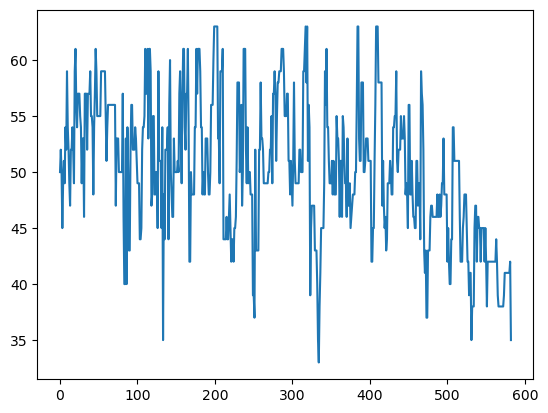

In [225]:
fssp = SolveFSSP(
    csv_path="operation_times.csv",
    initial_temperature=1000,
    final_temperature=1,
    cooling_rate=0.99,
    max_iterations=100000,
)

solution, solution_objective, objective_hystory = fssp.simulated_annealing()
print(f"Best solution found:\n {solution}")
print(f"Objective function value: {solution_objective}")
plt.plot(objective_hystory)

In [226]:
fssp.plot_gantt(solution)

Best solution found:
 [[0 2 3 4 1]
 [2 3 0 1 4]
 [2 3 1 4 0]]
Makespan: 33.0
